In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
auc_df = pd.read_csv('/kaggle/input/uk-energy-trading/auction_data.csv',delimiter=';')
auc_df.head()

In [ ]:
auc_df = auc_df[1:]
auc_df.info()

In [ ]:
auc_df['Date (WET)'] = auc_df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
auc_df[auc_df.columns[1:]] = auc_df[auc_df.columns[1:]].apply(lambda x: pd.to_numeric(x))
auc_df.head()

In [ ]:
auc_df=auc_df.dropna(how='all')

auc_df.duplicated().sum()

In [ ]:
def get_null_cols(df):
    null_dict = {}
    for i in df.columns:
        if df[i].isnull().sum()>0:
            null_dict[i] = df[i].isnull().sum()
    return null_dict

get_null_cols(auc_df)

In [ ]:
auc_df[auc_df.isnull().any(axis=1)].head(10)

In [ ]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = auc_df['price_forecast_first_auction'][:1500]
ref_df['tar'] = auc_df['price_forecast_first_auction'][:1476]
ref_df

In [ ]:
def search_filling_method(ref_df):
    ref_df = ref_df.assign(Rollavg=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).mean()))
    ref_df = ref_df.assign(RollMedian=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).median()))
    ref_df = ref_df.assign(InterpolateSpline3=ref_df.tar.interpolate(method='spline', order=3))
    ref_df = ref_df.assign(InterpolateSpline4=ref_df.tar.interpolate(method='spline', order=4))
    ref_df = ref_df.assign(InterpolateSpline5=ref_df.tar.interpolate(method='spline', order=5))

    results = [(method, np.sqrt(metrics.mean_squared_error(ref_df.ref, ref_df[method]))) 
               for method in list(ref_df)[2:]]
    results_df = pd.DataFrame(np.array(results), columns=['Method', 'RMSE'])
    results_df.sort_values(by='RMSE', ascending=False)
    return results_df
results_df = search_filling_method(ref_df)
results_df

In [ ]:
#Simple moving average method 
y_pred =auc_df.copy()
y_pred['price_forecast_first_auction'] = auc_df.price_forecast_first_auction.fillna(
    auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auc_df['price_forecast_first_auction'].loc[1300:1600], label='Train')
plt.plot(y_pred['price_forecast_first_auction'].loc[1536:1561], label='missing values')
plt.legend(loc='best')
plt.title('Simple Moving Average Method');

In [ ]:
auc_df.price_forecast_first_auction = auc_df.price_forecast_first_auction.fillna(
                                      auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())
auc_df = auc_df.bfill()
get_null_cols(auc_df)

In [ ]:
def read_preprocess(filepath):
    df = pd.read_csv(filepath,delimiter=';')
    df = df[1:]
    df['Date (WET)'] = df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x: pd.to_numeric(x,errors='coerce'))
    df = df.dropna(how='all')
    print(f'Duplicate rows:{df.duplicated().sum()}')
    print(f'Null Values:{get_null_cols(df)}')
    return df

sys_df = read_preprocess('/kaggle/input/uk-energy-trading/system_prices.csv')
print('\n')
sys_df.head()

In [ ]:
sys_df[sys_df.isnull().any(axis=1)].loc[1500:1550]

In [ ]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = sys_df['system_price'][:600]
ref_df['tar'] = sys_df['system_price'][:576]
search_filling_method(ref_df)

In [ ]:
#Simple moving median method 
y_pred =sys_df.copy()
y_pred['system_price'] = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(sys_df['system_price'].loc[300:700], label='Train')
plt.plot(y_pred['system_price'].loc[600:671], label='Missing values')
plt.legend(loc='best')
plt.title('Simple Moving Median Method for system_price');

#filling missing values
sys_df.system_price = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

In [ ]:
def miss_val_fill_method(df,u_index,l_index):
    miss_val_fill_methods = {}
    miss_val_cols = [i for i in get_null_cols(df) if get_null_cols(df)[i]>5]
    for col_name in miss_val_cols:
        ref_df = pd.DataFrame(columns=['ref','tar'])
        ref_df['ref'] = df[col_name][:u_index]
        ref_df['tar'] = df[col_name][:l_index]
        results_df = search_filling_method(ref_df)
        miss_val_fill_methods[col_name] = results_df.Method[0]
    return miss_val_fill_methods

result_dict= miss_val_fill_method(sys_df,1500,1476)
print(result_dict)
print('\n')

for col in result_dict.keys():
    print(f'missing values filled in {col}')
    sys_df[col] = sys_df[col].fillna(sys_df[col].rolling(25,min_periods=1,).mean())
sys_df = sys_df.bfill()
get_null_cols(sys_df)

In [ ]:
for_df = read_preprocess('/kaggle/input/uk-energy-trading/forecast_inputs.csv')
print('\n')
for_df.head()

In [ ]:
result_dict = miss_val_fill_method(for_df,1500,1476)
result_dict

In [ ]:
for col in result_dict.keys():
    print(f'missing values filled in {col}')
    for_df[col] = for_df[col].fillna(for_df[col].rolling(25,min_periods=1,).mean())
for_df = for_df.bfill()
get_null_cols(for_df)

In [ ]:
for_df = for_df.join(auc_df[['Date (WET)','price_second_auction','traded_volume_second_auction']].set_index(
                    'Date (WET)'),on='Date (WET)')
for_df = for_df.bfill()
for_df.head()

In [ ]:
for_df[for_df.describe().columns[1:]].skew(axis=0, skipna=True).sort_values(ascending=False)

In [ ]:
def draw_boxplot(df,cols):
    fig = plt.figure(figsize =(10, 5))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    bp = ax.boxplot(df[cols]);
    # x-axis labels
    ax.set_xticklabels(cols, rotation=90);
    
draw_boxplot(for_df,for_df.columns[1:])

In [ ]:
plt.figure(figsize=(10,10))
df_corr=for_df[for_df.columns[1:]].copy()
cor_df=df_corr.corr()
sns.heatmap(cor_df[(cor_df >= 0.5) | (cor_df <= -0.5)],annot=True,cmap='summer',mask = np.triu(cor_df),
            annot_kws={"fontsize":6});

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = for_df.columns[1:]
vif["vif_Factor"] = [variance_inflation_factor(np.array(for_df[for_df.columns[1:]].values, dtype=float), i) 
                     for i in range(for_df.shape[1]-1)]
vif[vif.vif_Factor>10].sort_values(by='vif_Factor',ascending=False)

In [ ]:
from sklearn.model_selection import train_test_split
feature_col_names = ['demand','within_day_availability', 'margin','long_term_wind', 
                     'long_term_solar', 'snsp_forecast','previous_day_ahead_price', 
                     'previous_continuous_half_hour_vwap','inertia_forecast','stack_price']


predict_col_name = ['price_second_auction']

for_df = for_df.set_index('Date (WET)') 
train = for_df.loc[:'2022-02-28']
test = for_df.loc['2022-03-01':]

X_train= train[feature_col_names]
X_test= test[feature_col_names]
y_train= train[predict_col_name]
y_test= test[predict_col_name]

print(f"{round(len(train)*100/len(for_df),2)}:{round(len(test)*100/len(for_df),2)}")

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
Rsq_train = linreg.score(X_train, y_train)
print("R square on training data: {}".format(round(Rsq_train,2)))
Rsq = linreg.score(X_test, y_test)
print("R square on testing data: {}".format(round(Rsq,2)))
adj_r2 = (1 - (1 - Rsq_train) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adj. R square on training data: {} %".format(round(adj_r2*100,2)))
adj_r2 = (1 - (1 - Rsq) * ((X_test.shape[0] - 1) / 
          (X_test.shape[0] - X_test.shape[1] - 1)))
print("Adj. R square on testing data: {} %".format(round(adj_r2*100,2)))
y_train_pred = linreg.predict(X_train)
y_pred = linreg.predict(X_test)
print("RMSE on train data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred)),2)))
print("RMSE on test data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),2)))

print('\n')
plt.scatter(x=y_test['price_second_auction'],y=y_pred);
plt.title('Actual vs Predicted scatter plot');
plt.xlabel("Actual price")
plt.ylabel("Predicted price");

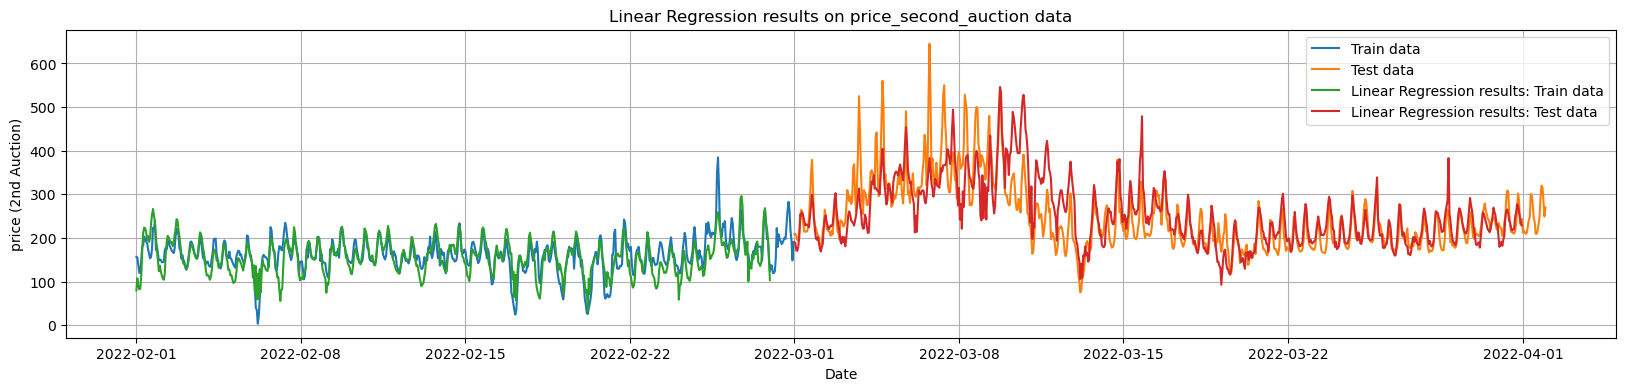

In [28]:
def plot_result(col,title,y_test_pred,y_train_pred): 
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(train[col].loc['2022-02-01':'2022-02-28'], label='Train data')
    plt.plot(test[col].loc['2022-03-01':'2022-04-01'], label='Test data')
    if len(y_train_pred)!=0:
        plt.plot(train.index[9506:10154], y_train_pred[9506:10154], label=title+": Train data")
    plt.plot(test.index[:743], y_test_pred[:743], label=title+": Test data")
    plt.legend(loc='best')
    plt.title(f"{title} on {col} data")
    plt.xlabel("Date")
    plt.ylabel("price (2nd Auction)");
plot_result('price_second_auction','Linear Regression results',y_pred,linreg.predict(X_train))

In [ ]:
def smape(Actual, Forcasted):
    return 100/len(Actual) * np.sum(2 * np.abs(Forcasted - Actual) / (np.abs(Actual) + np.abs(Forcasted)))

round(smape(test['price_second_auction'].values,  y_pred.ravel()),2)

In [ ]:
auc_df = auc_df.set_index('Date (WET)') 
auc_df = auc_df[~auc_df.index.duplicated()]
for_df = for_df[~for_df.index.duplicated()]
print(f"rows in forecasting data: {for_df.shape[0]}")
print(f"rows in auction data: {auc_df.shape[0]}")

In [31]:
auc_df['price_forecast_second_auction'] = linreg.predict(for_df[feature_col_names])
auc_df.head()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction
Date (WET),,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.956097
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.893960
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.561914
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.683111
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.643551
